# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/scripts_IBA')

In [ ]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Prak_MLMI',
 '/content/drive/MyDrive',
 '/content/drive/MyDrive/scripts_IBA']

In [ ]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

# try:
#     import IBA
# except ModuleNotFoundError:
#     sys.path.insert(0, '..')
#     import IBA

import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


## Loading Data and Model

### Insert the bottleneck into the model for NIH

You can experiment with the location of the bottleneck.

In [ ]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#checkpoint = torch.load('/content/drive/MyDrive/results/checkpoint_best', map_location=lambda storage, loc: storage)  #this is for GPU
#checkpoint = torch.load('/content/drive/MyDrive/results/checkpoint_best', map_location='cpu') 

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'   
checkpoint = torch.load('/content/drive/MyDrive/results/checkpoint_best', map_location=map_location)

model = checkpoint['model'].module
model.to(dev).eval()
print(model)





DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#%cd /content/drive/MyDrive 
!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
#%cd /content/drive/MyDrive/Colab\ Notebooks
#%cd /content/drive/MyDrive/scripts_IBA

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_014.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_015.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_016.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_017.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_018.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_019.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028897_020.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028898_000.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028899_000.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028899_001.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00028899_002.png  
  inflating: /content/drive/MyDrive/NIH_CXR14_Resized/NIH sm

In [ ]:
# load the data

PATH_TO_IMAGES = "/content/drive/MyDrive/NIH_CXR14_Resized"

if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224



# trainset = ImageFolder(
#     PATH_TO_IMAGES,
#     transform=Compose([
#         CenterCrop(256), Resize((image_size,image_size)), ToTensor(), 
#         Normalize(mean=0.485, std=0.229)
#     ]))

trainset = ImageFolder(
    PATH_TO_IMAGES,
    transform=Compose([
        CenterCrop(256), Resize((image_size,image_size)), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))




# with open(os.path.join(prak_dir, 'imagenet_class_index.json')) as f:
#     idx2class = {int(k): v[1] for k, v in json.load(f).items()}
#

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
 

In [ ]:


iba = IBA(model.features.denseblock2.denselayer6)



In [ ]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [ ]:
iba.estimate(model, trainloader, device=dev, n_samples=100, progbar=True)

In [ ]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

#(12, 3, 4) has mean -0.03 and std 0.17


Neuron at position (12, 3, 4) has mean -0.05 and std 0.11


In [ ]:
iba.estimator.n_samples()

128

In [ ]:
%matplotlib inline

## A image from the training set  (Question: normalize with imagenet mean and std, should calculate our own?)  inserted in denseblock2.denselayer6

In [ ]:
 
target = 1   # 1 = Cardiomegaly?
#%cd /content/drive/MyDrive/NIH_CXR14_Resized/NIH small
# preprocess image
# img  = Compose([
#     Resize((image_size,image_size)), ToTensor(),  
#     Normalize([0.485], [0.229])
# ])(Image.open("/content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00000001_000.png").convert('RGB') )

img  = Compose([
    Resize((image_size,image_size)), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open("/content/drive/MyDrive/NIH_CXR14_Resized/NIH small/00000001_000.png").convert('RGB') )

# img = torch.cat((img, img, img), axis=-1)
#img = torch.stack((img,)*3, axis=-1)




In [ ]:
img.shape 

torch.Size([3, 224, 224])

Old method


/content/drive/MyDrive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 128 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


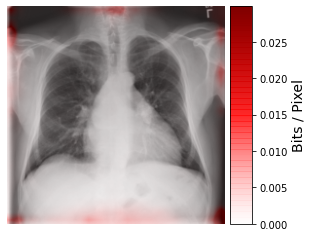

New method


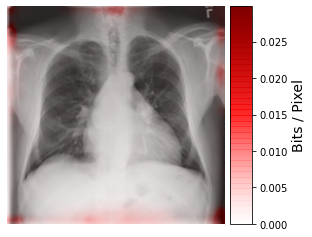

In [ ]:
print("Old method")
iba.reverse_lambda = False
iba.beta = 10
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
#_ = ax.set_title(idx2class[target])
plt.show()

print("New method")
iba.reverse_lambda = True
iba.beta = 30
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
#_ = ax.set_title(idx2class[target])
plt.show()

In [ ]:
print("Predict confidence without mask: {}".format(torch.softmax(model(img[None].to(dev)), 1)[:, 1].item()))
with iba.restrict_flow():
  print("Predict confidence mask: {}".format(torch.softmax(model(img[None].to(dev)), 1)[:, 1].item()))

Predict confidence without mask: 0.9387499690055847
Predict confidence mask: 0.9376272559165955


In [ ]:

#position = ["1","2"]
#print("model.features.denseblock{}.denselayer{}".format("1","2"))
# position = ["1","2"]
# print("model.features.denseblock{0}.denselayer{1}".format(*position))
positions = [["1","1"], ["1","6"], ["2","6"],["2","12"],["3","12"],["3","24"],["4","8"],["4","16"]]

model.features.denseblock1.denselayer2


## Try with different layers (old method)

/content/drive/MyDrive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 64 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


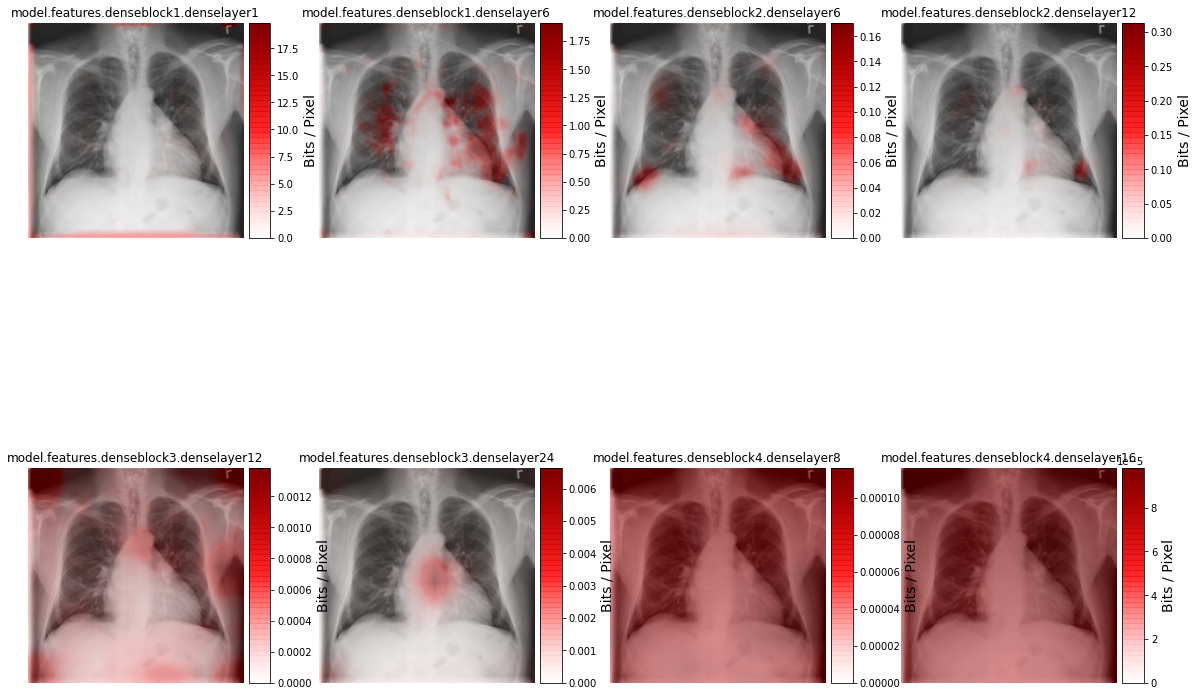

In [ ]:
# load image
fig, axes = plt.subplots(2, 4, figsize=(20,15))

positions = [["1","1"], ["1","6"], ["2","6"],["2","12"],["3","12"],["3","24"],["4","8"],["4","16"]]

for position, ax in zip(positions, axes.flatten()):
    current_pos = "model.features.denseblock{0}.denselayer{1}".format(*position)
    iba = IBA(eval(current_pos))
    iba.reset_estimate()
    iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)

    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
    ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
    ax.set_title(current_pos)

plt.show()

In [ ]:
iba.reverse_lambda

False

# Try with different layers (new method)

New method


/content/drive/MyDrive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 64 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


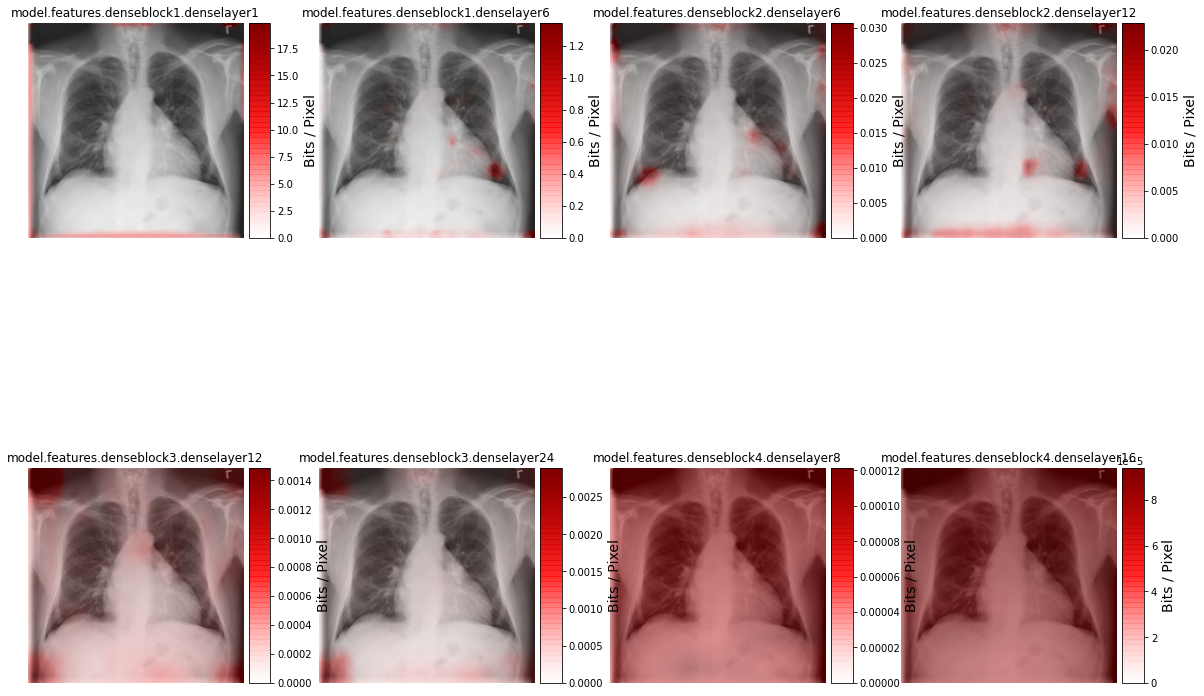

In [ ]:
print("New method")

# load image
fig, axes = plt.subplots(2, 4, figsize=(20,15))

positions = [["1","1"], ["1","6"], ["2","6"],["2","12"],["3","12"],["3","24"],["4","8"],["4","16"]]

for position, ax in zip(positions, axes.flatten()):
    current_pos = "model.features.denseblock{0}.denselayer{1}".format(*position)
    iba = IBA(eval(current_pos))
    iba.reset_estimate()
    iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=False)
    iba.reverse_lambda = True
    iba.beta = 30

    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
    ax = plot_saliency_map(heatmap, tensor_to_np_img(img), ax=ax)
    ax.set_title(current_pos)

plt.show()